In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hBeta import PThBeta
import seaborn as sns
import pathlib
import collections
from utils.utils_func import load_database, _inv_transform, sample_pca_residuals_distribution, save_xls
from preprocessing import epi_year_cases_matrix
import matplotlib.lines as mlines
from collections import defaultdict
from utils.utils_func import _sim_square_pos
from lalonde import _load_lalonde
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from causallib.estimation import StratifiedStandardization, Standardization
from sklearn.ensemble import RandomForestRegressor
from utils.utils_summary import _load_pickle, _dyadic_cube_to_samples, _dyadic_prediction, _dyadic_cube_to_samples222


sns.set_style("whitegrid")

### Load dataset - lalonde (1986) & pickle file of trained hBeta

In [2]:
dataset = 'X_lalonde'
X, y, a = _load_lalonde()
d_res, d_info = _load_pickle(file=('2_8_1_org'))

(22106, 10)


In [3]:
d_res, d_info = _load_pickle(file=('3_9_1_org_std'))

In [4]:
df_ipw = pd.DataFrame({'y':y, 'a':a})
df_ipw['prop'] = 0
df_ipw['prop_RCT'] = 0
df_ipw

,y,a,prop,prop_RCT
16827,31.03226,0.0,0,0
5412,19562.14000,0.0,0,0
15399,25564.67000,0.0,0,0
13077,18814.41000,0.0,0,0
2189,0.00000,0.0,0,0
...,...,...,...,...
11964,678.27650,0.0,0,0
21575,1053.61900,0.0,0,0
5390,21731.45000,0.0,0,0
860,13151.76700,0.0,0,0


In [4]:
d_res, d_info = _load_pickle(file=('2_10_1_org'))
# d_res, d_info = _load_pickle(file=('3_9_0.1_org'))
d_info

{'data': 'lalonde',
 'dim': 2,
 'seg_1dim': 5,
 'n_pts': 1000,
 'a_0': 1.0,
 'gamma': 0.1,
 'plot_pred': True,
 'transform': 'org',
 'loo': False,
 'positivity': True,
 'level': 10}

In [5]:
tr_prop, cr_prop = np.mean(a), 1-np.mean(a)
df = pd.DataFrame({'control': d_res['control']['pi'], 'treated': d_res['treated']['pi']})
df_sum_y = np.sum(df, axis=1)
propensity = (df['treated'] * tr_prop) / (df['control'] * cr_prop + df['treated'] * tr_prop)
propensity_RCT = (df['treated'] * 0.5) / (df['control'] * 0.5 + df['treated'] * 0.5)

,control,treated
78,0.740234,0.947299
149,0.231079,0.000180
150,0.017624,0.001375


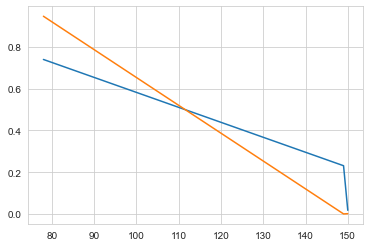

In [6]:
plt.plot(df.loc[np.sum(df > 0.005,axis=1) > 0, :]['control'])
plt.plot(df.loc[np.sum(df > 0.005,axis=1) > 0, :]['treated'])
df.loc[np.sum(df > 0.005,axis=1) > 0, :].head()

#### Set the space for the full X (treated and control), same cubes that were on the training process

In [7]:
pca = PCA(n_components=d_info['dim'])
principalComponents = pd.DataFrame(pca.fit_transform(X), index=X.index)
pca_full = pd.DataFrame(principalComponents)
print(pca.explained_variance_ratio_)

pt = PThBeta(seg_1dim=d_info['seg_1dim'])
pt.set_int_coords(data=pca_full, gamma=d_info['gamma'], sup_01=False)

[9.33578986e-01 6.64205150e-02 4.92263562e-07]


In [8]:
dyadic_sample = _dyadic_cube_to_samples(pca_full, pt)
dyadic_counts = defaultdict(dict)
for key in np.arange(2 ** d_info['level']):
    if dyadic_sample[key].shape[0] == 0:
        dyadic_sample.pop(key, None)
    else: 
        dyadic_counts['full'][key] = dyadic_sample[key].shape[0]
        dyadic_counts['control'][key] = np.sum(a.iloc[dyadic_sample[key]] == 0.0) # I changed to loc insted of iloc
        dyadic_counts['treatment'][key] = np.sum(a.iloc[dyadic_sample[key]] == 1.0) # I changed to loc insted of iloc
        #  add this in order to compute IPTW
        ind_c = dyadic_sample[key]
#         ind_t = a.iloc[dyadic_sample[key]].index[(a.iloc[dyadic_sample[key]] == 1.0).values]
        df_ipw.loc[ind_c, 'prop'] =  propensity[key]
        df_ipw.loc[ind_c, 'prop_RCT'] =  propensity_RCT[key]

df_counts = pd.DataFrame.from_dict(dyadic_counts)
df_counts['prop'] = propensity.iloc[df_counts.index]
df_counts['prop_RCT'] = propensity_RCT.iloc[df_counts.index]
df_counts.sort_values(by='prop', ascending=True).iloc[:20,:]

,full,control,treatment,prop,prop_RCT
220,14,14,0,0.000483,0.054188
221,3,3,0,0.002236,0.209896
148,1,1,0,0.009938,0.543174
157,2,2,0,0.011112,0.571169
156,1111,1111,0,0.035331,0.812999
84,1,1,0,0.097199,0.927384
204,1,1,0,0.123153,0.942974
92,4587,4545,42,0.138842,0.950655
293,1,1,0,0.244109,0.974740
227,7,7,0,0.251119,0.975651


In [72]:
df_ipw_clipped = df_ipw.loc[df_ipw['prop'] > 0.05, : ]



In [74]:
# IPW

np.mean((df_ipw['y'] * df_ipw['a']) / (df_ipw['prop']) - (df_ipw['y'] * (1-df_ipw['a'])) / (1-df_ipw['prop']))

-20890.57878849678

In [59]:
# Stabelized IPW

mu_1 = ((df_ipw['y'] * df_ipw['a']) / (df_ipw['prop'])) / (np.sum(df_ipw['a'] / df_ipw['prop']))
mu_0 = ((df_ipw['y'] * df_ipw['a']) / (df_ipw['prop'])) / (np.sum(df_ipw['a'] / df_ipw['prop']))

np.mean((df_ipw['y'] * (1-df_ipw['a'])) / (1-df_ipw['prop']))

21169.626279591652

In [60]:
np.mean(mu_1)

0.2819227414252747

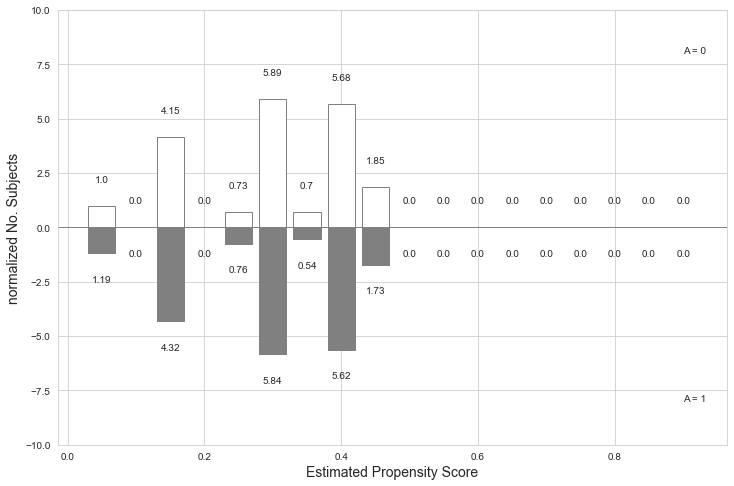

In [11]:
bins = np.arange(0.025, 0.975, 0.05)

top0, _ = np.histogram(df_ipw.loc[df_ipw['a']==0, 'prop'], bins=bins, density=True)
top1, _ = np.histogram(df_ipw.loc[df_ipw['a']==1, 'prop'], bins=bins, density=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_ylim(-10, 10)

ax.axhline(0, c='gray', linewidth=1)

bars0 = ax.bar(bins[:-1] + 0.025, top0, width=0.04, facecolor='white')
bars1 = ax.bar(bins[:-1] + 0.025, -top1, width=0.04, facecolor='gray')

for bars in (bars0, bars1):
    for bar in bars:
        bar.set_edgecolor("gray")

for x_, y_ in zip(bins, top0):
    ax.text(x_ + 0.025, y_ + 1, str(round(y_,2)), ha='center', va='bottom')

for x_, y_ in zip(bins, top1):
    ax.text(x_ + 0.025, -y_ - 1, str(round(y_,2)), ha='center', va='top')

ax.text(0.9,  8, "A = 0")
ax.text(0.9, -8, "A = 1")

ax.set_ylabel("normalized No. Subjects", fontsize=14)
ax.set_xlabel("Estimated Propensity Score", fontsize=14);


In [13]:
df_ipw['prop'].max()

0.49900978803634644

In [14]:
cond_0 = df_ipw.loc[:,'a'] == 0
cond = df_ipw.loc[:,'a'] == 1

df_ipw['a'] = a
df_ipw.loc[cond_0, 'weight'] = 1/ (1-df_ipw['prop'])
df_ipw.loc[cond, 'weight'] = 1/ df_ipw['prop']
df_ipw.loc[cond_0, 'weight_RCT'] = 1/ (1-df_ipw['prop_RCT'])
df_ipw.loc[cond, 'weight_RCT'] = 1/ df_ipw['prop_RCT']

In [15]:
df_ipw['prop'] > 0.01

16827    True
5412     True
15399    True
13077    True
2189     True
         ... 
11964    True
21575    True
5390     True
860      True
15795    True
Name: prop, Length: 22106, dtype: bool

In [17]:

mu_0 = np.mean(df_ipw.loc[cond_0, 'y'] * df_ipw.loc[cond_0, 'weight'])
mu_1 = np.mean(df_ipw.loc[cond, 'y'] * df_ipw.loc[cond, 'weight'])

mu_1 - mu_0 

11995.627499401173

In [18]:
mu_0

21348.2851392114

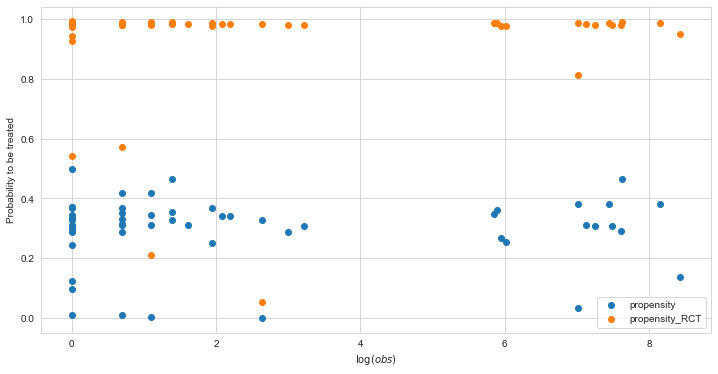

In [19]:
plt.subplots(figsize=(12,6))
plt.scatter(x=np.log(df_counts['full']), y=df_counts['prop'], label='propensity')
plt.scatter(x=np.log(df_counts['full']), y=df_counts['prop_RCT'], label='propensity_RCT')
plt.xlabel('$\log(obs)$')
plt.ylabel('Probability to be treated')
plt.legend()

In [80]:
est = StratifiedStandardization(LinearRegression()) #
avg_outcome_dict = defaultdict(dict)
th = np.linspace(0, 0.02, 500) # 0.03
for ind, t in enumerate(th):
    cond = (df_counts['prop'] > t) ###OPOSITE DIRECTION #| ((1 - df_counts['prop_RCT']) < t) 
    keys_cond = cond[cond == True].index
    cc = np.array([])
    for key in keys_cond:
        cc = np.append(cc, dyadic_sample[key])
    X_tilde, a_tilde, y_tilde = X.iloc[cc,:], a.iloc[cc], y.iloc[cc]
    if (ind % 10) == 0:
        print("treated:{}, control:{}, th:{:f}".format(np.sum(a_tilde), np.sum(a_tilde==0), t))
    est.fit(X=X_tilde, a=a_tilde, y=y_tilde)
    avg_outcomes = est.estimate_population_outcome(X_tilde, a_tilde)
    avg_outcome_dict['control'][t] = avg_outcomes.iloc[0]
    avg_outcome_dict['treatment'][t] = avg_outcomes.iloc[1]
df_avg_outcomes = pd.DataFrame.from_dict(avg_outcome_dict)
# avg_outcomes

treated:185.0, control:21921, th:0.000000
treated:185.0, control:21904, th:0.008016
treated:185.0, control:21901, th:0.016032
treated:185.0, control:21901, th:0.024048
treated:185.0, control:21901, th:0.032064
treated:185.0, control:20790, th:0.040080
treated:185.0, control:20790, th:0.048096
treated:185.0, control:20790, th:0.056112
treated:185.0, control:20790, th:0.064128
treated:185.0, control:20790, th:0.072144
treated:185.0, control:20790, th:0.080160
treated:185.0, control:20790, th:0.088176
treated:185.0, control:20790, th:0.096192
treated:185.0, control:20789, th:0.104208
treated:185.0, control:20789, th:0.112224
treated:185.0, control:20789, th:0.120240
treated:185.0, control:20788, th:0.128257
treated:185.0, control:20788, th:0.136273
treated:143.0, control:16243, th:0.144289
treated:143.0, control:16243, th:0.152305
treated:143.0, control:16243, th:0.160321
treated:143.0, control:16243, th:0.168337
treated:143.0, control:16243, th:0.176353
treated:143.0, control:16243, th:0

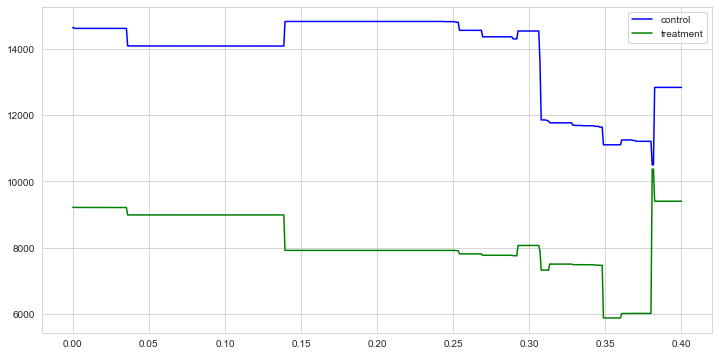

In [81]:
plt.subplots(figsize=(12,6))
plt.plot(df_avg_outcomes.index, df_avg_outcomes['control'], label='control', c='b')
plt.plot(df_avg_outcomes.index, df_avg_outcomes['treatment'], label='treatment', c='g')
plt.legend()

$E[E[Y|X=x,A=1]]$ , $E[E[Y|X=x,A=0]]$

### Inclusion criteria

In [82]:
cond = (df_counts['prop'] > 0.01) ###OPOSITE DIRECTION #| ((1 - df_counts['prop_RCT']) < t) 
avg_keys_treated, avg_keys_control = dict(), dict()
keys_cond = cond[cond == True].index
cc = np.array([])
for key in keys_cond:
    cc = np.append(cc, dyadic_sample[key])
    # temp var
    k = (a.iloc[dyadic_sample[key]] == 0).reset_index()
    ind_cr = k.loc[(k['training'] == True).values, :]['index']
    ind_tr = k.loc[(k['training'] == False).values, :]['index']
    avg_keys_treated[key] = np.mean(y.loc[ind_tr])
    avg_keys_control[key] = np.mean(y.loc[ind_cr])
X_tilde, a_tilde, y_tilde = X.iloc[cc,:], a.iloc[cc], y.iloc[cc]

(array([5.965e+03, 2.740e+03, 3.119e+03, 3.045e+03, 6.462e+03, 3.240e+02,
        1.910e+02, 9.200e+01, 6.000e+01, 2.400e+01, 1.500e+01, 9.000e+00,
        1.400e+01, 9.000e+00, 5.000e+00, 0.000e+00, 6.000e+00, 4.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([     0.  ,   5507.89,  11015.78,  16523.67,  22031.56,  27539.45,
         33047.34,  38555.23,  44063.12,  49571.01,  55078.9 ,  60586.79,
         66094.68,  71602.57,  77110.46,  82618.35,  88126.24,  93634.13,
         99142.02, 104649.91, 110157.8 , 115665.69, 121173.58]),
 <BarContainer object of 22 artists>)

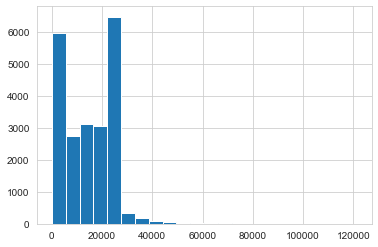

In [83]:
plt.hist(y_tilde, bins = 22)

Text(0.5, 1.0, 'Propensity score at the subspace of $X_{PCA}$\n(in white-cells with observations)')

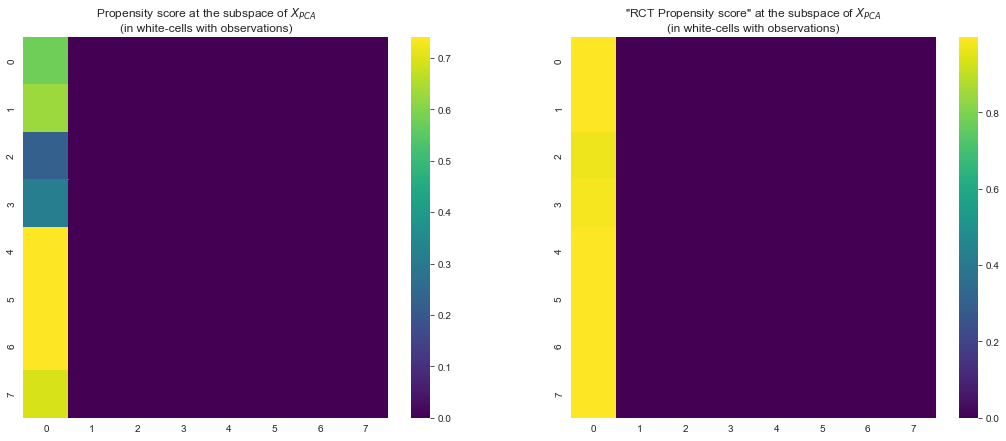

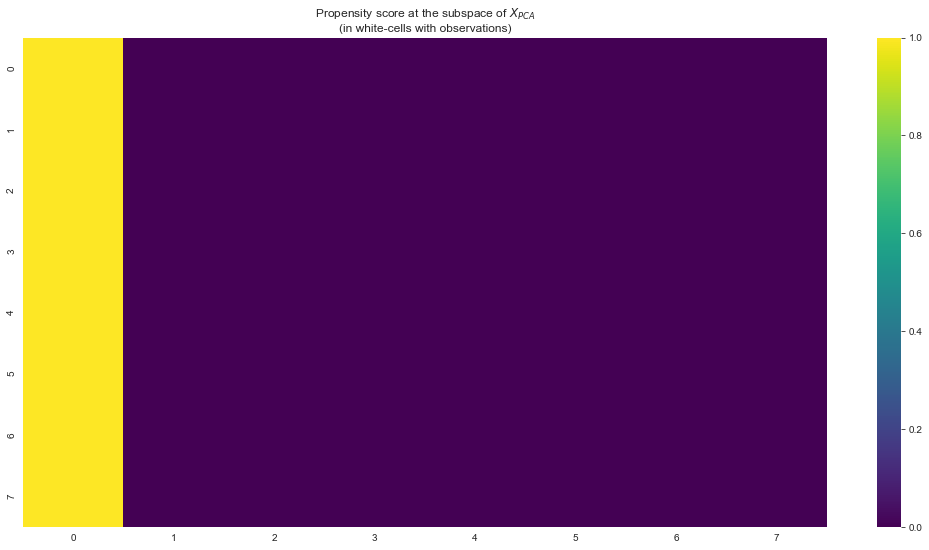

In [84]:
fig, ax = plt.subplots(ncols= 2, figsize=(18, 7))
inc_crit, inc_crit_RCT = np.zeros((pt.intervals_1dim, pt.intervals_1dim)), np.zeros((pt.intervals_1dim, pt.intervals_1dim))
for i in range(pt.intervals_1dim * pt.intervals_1dim):
    inc_crit_RCT[pt.arr_ind[i, 1], pt.arr_ind[i, 0]] = propensity_RCT[i] 
    inc_crit[pt.arr_ind[i, 1], pt.arr_ind[i, 0]] = propensity[i] 
    
df_heat, df_heat_RCT = pd.DataFrame(inc_crit), pd.DataFrame(inc_crit_RCT)  
ax[0] = sns.heatmap(df_heat, cmap = plt.get_cmap('viridis'), ax=ax[0])
ax[1] = sns.heatmap(df_heat_RCT, cmap = plt.get_cmap('viridis'),ax=ax[1])


from matplotlib.patches import Rectangle
cond = (df_counts['prop'] > 0) ###OPOSITE DIRECTION #| ((1 - df_counts['prop_RCT']) < t) 
keys_cond = cond[cond == True].index
# for key in keys_cond:
#     ax[0].add_patch(Rectangle((pt.arr_ind[key, 0], pt.arr_ind[key, 1]), 1, 1, fill=False, edgecolor='white', lw=2))
#     ax[1].add_patch(Rectangle((pt.arr_ind[key, 0], pt.arr_ind[key, 1]), 1, 1, fill=False, edgecolor='white', lw=2))

ax[0].set_title('Propensity score at the subspace of $X_{PCA}$\n(in white-cells with observations)')
ax[1].set_title('"RCT Propensity score" at the subspace of $X_{PCA}$\n(in white-cells with observations)')


# binary - below or above threshold
fig, ax = plt.subplots(ncols= 1, figsize=(18, 9))
inc_crit, inc_crit_RCT = np.zeros((pt.intervals_1dim, pt.intervals_1dim)), np.zeros((pt.intervals_1dim, pt.intervals_1dim))
for i in range(pt.intervals_1dim * pt.intervals_1dim):
    inc_crit[pt.arr_ind[i, 1], pt.arr_ind[i, 0]] = propensity[i]>0.01 
    
df_heat, df_heat_RCT = pd.DataFrame(inc_crit), pd.DataFrame(inc_crit_RCT)  
ax = sns.heatmap(df_heat, cmap = plt.get_cmap('viridis'), ax=ax)

ax.set_title('Propensity score at the subspace of $X_{PCA}$\n(in white-cells with observations)')


Text(0.5, 1.0, 'The subspace of $X_{PCA}$\n(red frame-cells with observed data, yellow-cells which were not omitted')

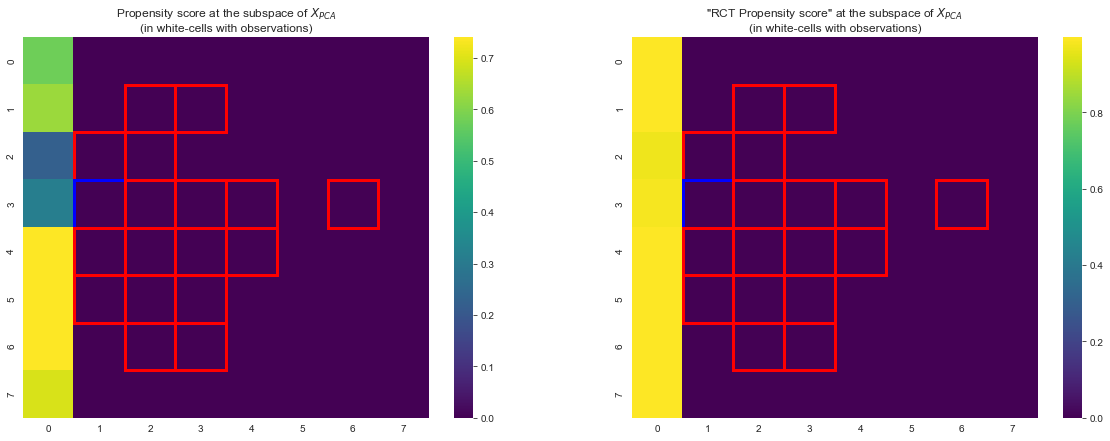

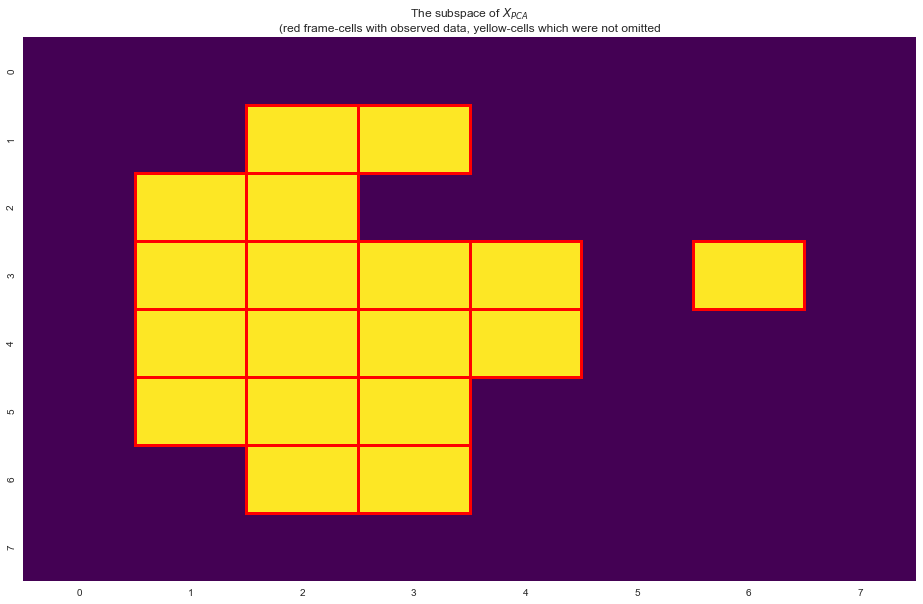

In [85]:
fig, ax = plt.subplots(ncols= 2, figsize=(20, 7))
inc_crit, inc_crit_RCT = np.zeros((pt.intervals_1dim, pt.intervals_1dim)), np.zeros((pt.intervals_1dim, pt.intervals_1dim))
for i in range(pt.intervals_1dim * pt.intervals_1dim):
    inc_crit_RCT[pt.arr_ind[i, 1], pt.arr_ind[i, 0]] = propensity_RCT[i] 
    inc_crit[pt.arr_ind[i, 1], pt.arr_ind[i, 0]] = propensity[i] 
    
df_heat, df_heat_RCT = pd.DataFrame(inc_crit), pd.DataFrame(inc_crit_RCT)  
ax[0] = sns.heatmap(df_heat, cmap = plt.get_cmap('viridis'), ax=ax[0])
ax[1] = sns.heatmap(df_heat_RCT, cmap = plt.get_cmap('viridis'),ax=ax[1])


from matplotlib.patches import Rectangle
cond = (df_counts['prop'] > 0) ###OPOSITE DIRECTION #| ((1 - df_counts['prop_RCT']) < t) 
keys_cond = cond[cond == True].index
for key in keys_cond:
    if df_counts.loc[key, 'treatment'] == 0:
        ax[0].add_patch(Rectangle((pt.arr_ind[key, 0], pt.arr_ind[key, 1]), 1, 1, fill=False, edgecolor='red', lw=3))
        ax[1].add_patch(Rectangle((pt.arr_ind[key, 0], pt.arr_ind[key, 1]), 1, 1, fill=False, edgecolor='red', lw=3))
    else:
        ax[0].add_patch(Rectangle((pt.arr_ind[key, 0], pt.arr_ind[key, 1]), 1, 1, fill=False, edgecolor='blue', lw=3))
        ax[1].add_patch(Rectangle((pt.arr_ind[key, 0], pt.arr_ind[key, 1]), 1, 1, fill=False, edgecolor='blue', lw=3))
ax[0].set_title('Propensity score at the subspace of $X_{PCA}$\n(in white-cells with observations)')
ax[1].set_title('"RCT Propensity score" at the subspace of $X_{PCA}$\n(in white-cells with observations)')
# plt.show()


fig, ax = plt.subplots(ncols= 1, figsize=(16, 10))
inc_crit = np.zeros((pt.intervals_1dim, pt.intervals_1dim))
cond = (df_counts['prop'] > 0.01) ###OPOSITE DIRECTION #| ((1 - df_counts['prop_RCT']) < t) 
keys_cond = cond[cond == True].index
for key in keys_cond:
    inc_crit[pt.arr_ind[key, 1], pt.arr_ind[key, 0]] = 1 
df_heat = pd.DataFrame(inc_crit)  
ax = sns.heatmap(df_heat, cmap = plt.get_cmap('viridis'), ax= ax, cbar=False)

for ind in df_counts.index:
    ax.add_patch(Rectangle((pt.arr_ind[ind, 0], pt.arr_ind[ind, 1]), 1, 1, fill=False, edgecolor='red', lw=3))

ax.set_title('The subspace of $X_{PCA}$\n(red frame-cells with observed data, yellow-cells which were not omitted')

In [25]:
cond = (df_counts['prop'] > 0.000000001) ###OPOSITE DIRECTION #| ((1 - df_counts['prop_RCT']) < t) 
avg_keys_treated, avg_keys_control = dict(), dict()
keys_cond = cond[cond == True].index
cc = np.array([])
for key in keys_cond:
    cc = np.append(cc, dyadic_sample[key])
    # temp var
    k = (a.iloc[dyadic_sample[key]] == 0).reset_index()
    ind_cr = k.loc[(k['training'] == True).values, :]['index']
    ind_tr = k.loc[(k['training'] == False).values, :]['index']
    avg_keys_treated[key] = np.mean(y.loc[ind_tr])
    avg_keys_control[key] = np.mean(y.loc[ind_cr])
X_tilde, a_tilde, y_tilde = X.iloc[cc,:], a.iloc[cc], y.iloc[cc]


cond = (df_counts['prop'] > 0.01) ###OPOSITE DIRECTION #| ((1 - df_counts['prop_RCT']) < t) 
avg_keys_cropped_treated, avg_keys_cropped_control = dict(), dict()
keys_cond = cond[cond == True].index
cc = np.array([])
for key in keys_cond:
    cc = np.append(cc, dyadic_sample[key])
    # temp var
    k = (a.iloc[dyadic_sample[key]] == 0).reset_index()
    ind_cr = k.loc[(k['training'] == True).values, :]['index']
    ind_tr = k.loc[(k['training'] == False).values, :]['index']
    avg_keys_cropped_treated[key] = np.mean(y.loc[ind_tr])
    avg_keys_cropped_control[key] = np.mean(y.loc[ind_cr])

In [144]:
df

,control,treated
0,9.147626e-07,0.000080
1,8.385825e-07,0.000078
2,8.654126e-07,0.000071
3,1.007724e-06,0.000073
4,1.126722e-06,0.000076
...,...,...
1019,2.835932e-07,0.000013
1020,2.422506e-07,0.000015
1021,2.438260e-07,0.000015
1022,2.253514e-07,0.000017


ATT: -2.180684
ATT clipped: -2.180684


Text(0.5, 1.0, 'clipped Weighted Effect per cell\n(only cell with treated obs)')

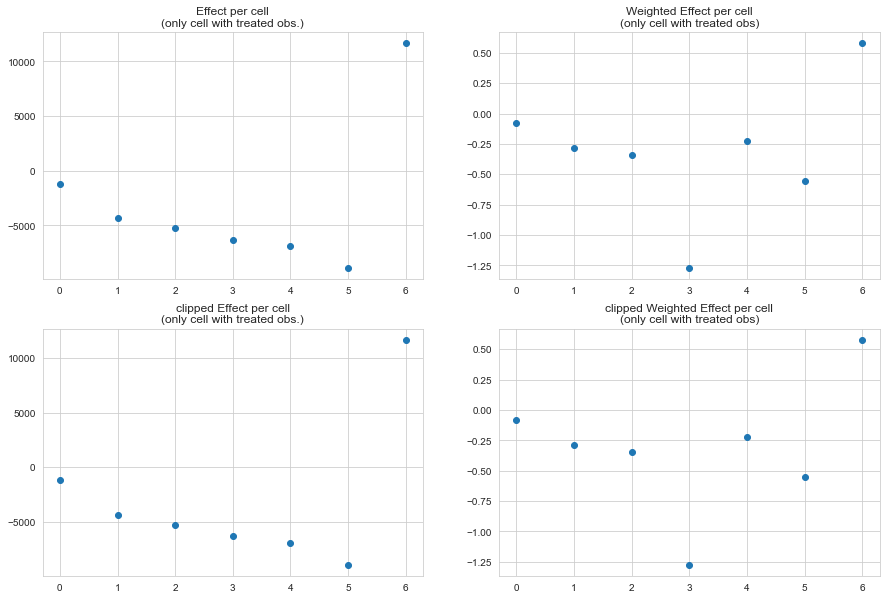

In [86]:
ind = avg_keys_control.keys()
eff_unweighted = (pd.Series(avg_keys_treated) - pd.Series(avg_keys_control)).dropna()
eff_weigthed_tr = (df['treated'].loc[ind] * pd.Series(avg_keys_treated) - df['treated'].loc[ind] * pd.Series(avg_keys_control)).dropna()

eff_unweighted_cropped = (pd.Series(avg_keys_cropped_treated) - pd.Series(avg_keys_cropped_control)).dropna()
eff_weigthed_tr_cropped = (df['treated'].loc[ind] * pd.Series(avg_keys_cropped_treated) - df['treated'].loc[ind] * pd.Series(avg_keys_cropped_control)).dropna()


print('ATT: {:f}'.format(np.sum(eff_weigthed_tr)))
print('ATT clipped: {:f}'.format(np.sum(eff_weigthed_tr_cropped)))


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax[0, 0].scatter(x=np.arange(eff_weigthed_tr.shape[0]), y=eff_unweighted)
ax[0, 0].set_title('Effect per cell\n(only cell with treated obs.)')
ax[0, 1].scatter(x=np.arange(eff_weigthed_tr.shape[0]), y=eff_weigthed_tr)
ax[0, 1].set_title('Weighted Effect per cell\n(only cell with treated obs)')

ax[1, 0].scatter(x=np.arange(eff_weigthed_tr_cropped.shape[0]), y=eff_unweighted_cropped)
ax[1, 0].set_title('clipped Effect per cell\n(only cell with treated obs.)')
ax[1, 1].scatter(x=np.arange(eff_weigthed_tr_cropped.shape[0]), y=eff_weigthed_tr_cropped)
ax[1, 1].set_title('clipped Weighted Effect per cell\n(only cell with treated obs)')

In [27]:
eff_unweighted

89     -1188.914620
90     -4332.160526
91     -5247.420167
92     -6296.416142
99     -6901.147302
100    -8909.077481
164    11651.366016
dtype: float64

In [ ]:
# JUST CHECKING


def _dyadic_cube_to_samples_checks(X, pt):
    min_dyc = pt.arr_med - pt.diff_vec / 2
    max_dyc = pt.arr_med + pt.diff_vec / 2
    int_mat = pt.arr_ind @ pt.weight_vec
    d = dict.fromkeys(int_mat, 0)
    if X.shape[1] == 2:
        for pt_cell in d:
            temp = ((X.iloc[:, 0] < max_dyc[pt_cell, 0]) & (X.iloc[:, 1] < max_dyc[pt_cell, 1])) \
                   & ((X.iloc[:, 0] > min_dyc[pt_cell, 0]) & (X.iloc[:, 1] > min_dyc[pt_cell, 1]))
            d[pt_cell] = temp.loc[temp == True].index
    else:
        for pt_cell in d:
            temp = np.where(((X.iloc[:, 0] < max_dyc[pt_cell, 0]) & (X.iloc[:, 1] < max_dyc[pt_cell, 1]) &
                                   (X.iloc[:, 2] < max_dyc[pt_cell, 2])) &
                                  ((X.iloc[:, 0] > min_dyc[pt_cell, 0]) & (X.iloc[:, 1] > min_dyc[pt_cell, 1]) &
                                   (X.iloc[:, 2] > min_dyc[pt_cell, 2])))[0]
            d[pt_cell] = temp.loc[temp == True].index
    return d


In [118]:
min_dyc = pt.arr_med - pt.diff_vec / 2
max_dyc = pt.arr_med + pt.diff_vec / 2
int_mat = pt.arr_ind @ pt.weight_vec
d = dict.fromkeys(int_mat, 0)
pt_cell = 162
temp = (((pca_full.iloc[:, 0] < max_dyc[pt_cell, 0]) & (X.iloc[:, 1] < max_dyc[pt_cell, 1]) & 
        (pca_full.iloc[:, 2] < max_dyc[pt_cell, 2])) & 
((pca_full.iloc[:, 0] > min_dyc[pt_cell, 0]) & (pca_full.iloc[:, 1] > min_dyc[pt_cell, 1]) &
                       (pca_full.iloc[:, 2] > min_dyc[pt_cell, 2])))
np.sum(temp)

IndexError: index 162 is out of bounds for axis 0 with size 16

In [132]:
from causallib.estimation import IPW
learner = LogisticRegression(penalty='none',  # No regularization, new in scikit-learn 0.21.*
                             solver='lbfgs',
                             max_iter=500)   
ipw = IPW(learner)

est = StratifiedStandardization(LinearRegression())


avg_outcome_dict = defaultdict(dict)
th = np.linspace(0, 0.025, 70)
for t in th:
    cond = (df_counts['prop'] < t) #| ((1 - df_counts['prop_RCT']) < t) 
    keys_cond = cond[cond == True].index
    cc = np.array([])
    for key in keys_cond:
        cc = np.append(cc, dyadic_sample[key])
    X_tilde, a_tilde, y_tilde = X.drop(index=cc), a.drop(index=cc), y.drop(index=cc)
    est.fit(X=X_tilde, a=a_tilde, y=y_tilde)
    ipw.fit(X=X_tilde, a=a_tilde)
    avg_outcomes = est.estimate_population_outcome(X_tilde, a_tilde)
    outcomes_ipw = ipw.estimate_population_outcome(X_tilde, a_tilde, y_tilde)
    avg_outcome_dict['control'][t] = avg_outcomes.iloc[0]
    avg_outcome_dict['treatment'][t] = avg_outcomes.iloc[1]
    avg_outcome_dict['control_ipw'][t] = outcomes_ipw.iloc[0]
    avg_outcome_dict['treatment_ipw'][t] = outcomes_ipw.iloc[1]
df_avg_outcomes = pd.DataFrame.from_dict(avg_outcome_dict)
# avg_outcomes